# [Jigsaw] Simple LGBM starter using TF-IDF

This is a simple LightGBM starter using TF-IDF only.  
The reason why used TF-IDF only is based on the thought that wheter "toxic" or not would be depending on the existance of the specific violent or obscene words in the sentences.  

Just FYI, I attached improvement history as below.  
As Data description says, there is no training data for this competition. Hence, please add the training data from "jigsaw-toxic-comment-classification-challenge".


TF-IDFを使ったLightGBMによるシンプルなStarterです。  
TF-IDFのみを使ったのは、「害のある文章」かどうかというのは或る特定の語（暴力的・卑猥等）が文章中に存在するかどうかによって決まることが多いのではないかという考えからです。  
ご参考までに、当初のバージョンからの改修履歴を付けました。  

本コンペのData descriptionに記載の通り、このコンペにはTrainingデータがありませんので、過去の"jigsaw-toxic-comment-classification-challenge"からデータを追加してください。

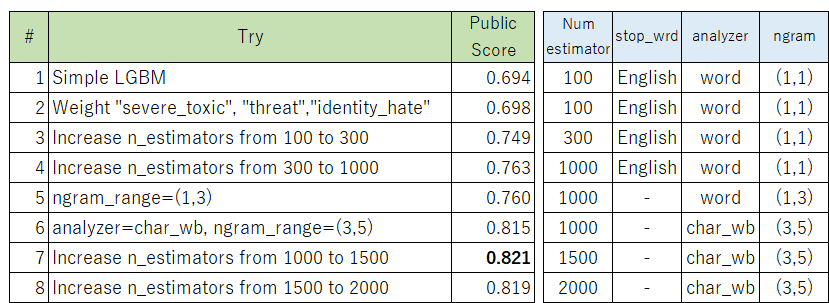

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
comments_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv")
valid_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv")

comments_df

Reading the training data from past "jigsaw-toxic-comment-classification-challenge".

学習用に、過去の「jigsaw-toxic-comment-classification-challenge」のトレーニングデータを読み込む。

In [ ]:
prev_train_df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
prev_train_df

From a quick look, we can see "non-toxic" sentences only.  
Let's take a look at "toxic" sentences.  

上記トレーニングデータには、害がない文章しか見えない。害のある文章はどのようなものか見てみる。

In [ ]:
prev_train_df[prev_train_df["toxic"] > 0]

Then, let's count each factor,meaning, toxic, sever_toxic, obscene, threat, insult and identity_hate.

次に、toxic(害がある)、severe_toxic（非常に害がある）、obscene（猥褻な）、threat（脅しの）、insult（侮蔑的な）、identity_hate（差別的な、と捉えるのがよいのでしょうか）がどの程度あるのか見てみる。

In [ ]:
for col in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] :
    print(col, prev_train_df[col].sum())

Toxic rows are 15,294, which is apprx 10% out of total training data 159,571 rows. It seems almost rows are non-toxic. "threat" is only 478 rows, which is 0.3%.   
Try to weighten some rare items, then newly creat "total_toxic". 

トレーニングデータ159,571行のうち、toxicは15,294で1割程度。殆どが「害のない」文章のようだ。threat（脅し）に至っては478と僅か0.3%。レア度が違うのに、カウントとしては同じ「1」というのも違和感あるので、レアな項目の重みを増してみる。  
その上で、「total_toxic」を新設する。

In [ ]:
prev_train_df["severe_toxic"] = prev_train_df["severe_toxic"] * 2.5
prev_train_df["threat"] = prev_train_df["threat"] *3
prev_train_df["identity_hate"] = prev_train_df["identity_hate"] * 2

prev_train_df["total_toxic"] = prev_train_df[["toxic", "severe_toxic", "obscene", "threat", "insult",
                                              "identity_hate"]].sum(axis = 1).astype(np.int64)

In [ ]:
train_df = prev_train_df[["comment_text", "total_toxic"]]
train_df

Try to see how the score will be improved by changing ngram.  
First, tried to change ngram=(1, 3) with analyzer=default, meaning "word". Then the score became slightly worse from 0.763 to 0.760.  
Next, tried to change ngram=(3,5) with analyzer=**char_wb**, then score got much improved to **0.815**  
I guess, in case that multiple words are concatinated for example "gofuckyou" in below rows, analyzer=char_wb(ngram=3~5) can pick up "fuck" and it would improve the accuracy, while analyzer=word will capture the entire as a single word. 

Furthermore, the public score was improved from 0.815 to **0.821** by increasing n_estimatos from 1000 to 1500.

However, when increasing n_estimators from 1500 to 2000, the score got worse from 0.821 to 0.819. Looks like the number of learning times is too much and resulted in overfitting. I think approx 1500 would be the best for the number of learning.  

ngramを変更してどうスコアが変わるかを試してみる。単語単位でngram範囲を1～3で試してみると、スコアは0.763→0.760へと僅かに低下。  
一方、単語単位ではなく、単語内文字単位(**char_wb**）でngram範囲を3～5で試してみると、スコアは**0.815**へと大きく改善。  
おそらく、以下に見られるような"gofuckyourelf"のように複数単語が切れ目なく繋がっている場合に、analyzer=wordだと全体を一語として捉えてしまうのに対し、analyzer=char_wb (ngram=3~5)にするとfuck部分をうまく拾えるので精度が上がるためではないかと思う。

ここからさらに、n_estimatorsを1000→1500に増やしてみると、スコアは0.815から**0.821**に改善。

一方、n_estimatorsをさらに1500→2000に増やすと、スコアは0.821から0.819へと悪化。学習回数が多すぎて過学習になったものと思われるので、学習回数は1500程度が良いものと思われる。

In [ ]:
prev_train_df.loc[prev_train_df["comment_text"].str.contains("fuckyou"), "comment_text"]

In [ ]:
#tfvec = TfidfVectorizer(stop_words="english")
tfvec = TfidfVectorizer(analyzer = 'char_wb', ngram_range = (3,5))
tfv = tfvec.fit_transform(train_df["comment_text"])

In [ ]:
lgb_params = {
    "objective": "regression",
    "n_estimators" : 2000,
    "random_seed" : 1234}

model = lgbm.LGBMRegressor(**lgb_params)

In [ ]:
model.fit(tfv, train_df["total_toxic"])

In [ ]:
tfv_comments = tfvec.transform(comments_df["text"])
pred = model.predict(tfv_comments)

In [ ]:
sub = pd.DataFrame()
sub["comment_id"] = comments_df["comment_id"]
sub["score"] = pred
sub.to_csv('submission.csv',index=False)
sub